# Simulation Script

13-06-24

Katie Willis

Katie.willis@imperial.ac.uk

_____

This file contains code required to generate all figures and values associated with the manuscript titled "Engineering drive-selection balance for localised population suppression with neutral dynamics".


### Setup 

Activate environment for loading packages

In [1]:
] activate ./Environment

  Activating project at `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Manuscripts/2024_PDNE/GithubFiles/Environment`


In [2]:
] status

Status `~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Manuscripts/2024_PDNE/GithubFiles/Environment/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
  [8bb1440f] DelimitedFiles v1.9.1
⌃ [31c24e10] Distributions v0.25.107
⌃ [033835bb] JLD2 v0.4.45
  [0db19996] NBInclude v2.3.0
⌃ [91a5bcdd] Plots v1.39.0
  [d330b81b] PyPlot v2.11.2
⌃ [24249f21] SymPy v2.0.1
  [bd369af6] Tables v1.11.1
  [8ba89e20] Distributed
  [37e2e46d] LinearAlgebra
Info Packages marked with ⌃ have new versions available and may be upgradable.


Load packages and functions

In [3]:
using NBInclude
@nbinclude("./Environment/Setup.ipynb");
@nbinclude("./SimulationFunctions.ipynb");

This code is written such that it uses pre-defined gamete and fitness tables located in folders for each model. Functions (shared between models) are then used to run simulations of different populations.

To allow sharing of functions across models we label alleles at the first locus as A1...An for n number of alleles and at the second locus B1...Bm for m alelles etc. Thus the labels used in the code differ from those referred to in the written methods. These labels are made clear throughout the code.

In [4]:
#Create output directories for generated data files
mkpath("./results/SingleLocus/")
mkpath("./results/SingleLocusLOF/")
mkpath("./results/TwoLocus/")
mkpath("./results/TwoLocusNoRsc/")
mkpath("./results/HomingBooster/");

## Figure 1 (From analytical model equations)

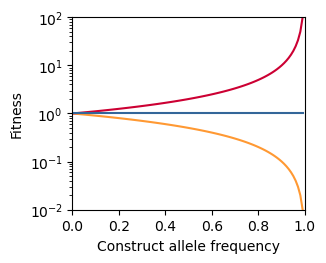

In [31]:
# plot fitness
#frequencies
G_rec = collect(0:0.01:0.9999)
#REC
w1_G = 1 .- G_rec
#DOM
w2_G = 1 ./(1 .- G_rec)
#Total
w_G = w1_G .* w2_G

f1 = PyPlot.figure(figsize=(3,2.5))

PyPlot.plot(G_rec,w1_G,"#FF9933",label = "w1")
PyPlot.plot(G_rec,w2_G,"#CC0033",label = "w2")
PyPlot.plot(G_rec,w_G,"#336699",label = "w")

PyPlot.xlabel("Construct allele frequency")
PyPlot.ylabel("Fitness")
PyPlot.yscale("log")
PyPlot.ylim(0.01,100)
PyPlot.xlim(0,1)
PyPlot.show()


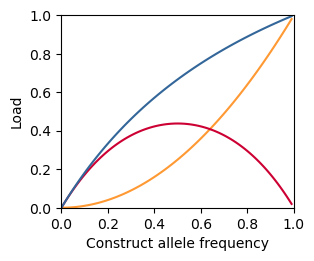

In [32]:
#Plot load


#Frequencies
G_rec = collect(0:0.01:0.9999)
#Recessive load
L1_G = G_rec.^2
#Dominant load
L2_G = 1 .- (1 .+ (-1 .+ G_rec) .*G_rec).^2
#Total load 
L_G = (2 .* G_rec) ./ (1 .+ G_rec)

f1 = PyPlot.figure(figsize=(3,2.5))

PyPlot.plot(G_rec,L1_G,"#FF9933",linestyle ="-",label = "w1")
PyPlot.plot(G_rec,L2_G,"#CC0033",label = "w2")
PyPlot.plot(G_rec,L_G,"#336699",label = "w")

PyPlot.xlabel("Construct allele frequency")
PyPlot.ylabel("Load")
PyPlot.xlim(0,1)
PyPlot.ylim(0,1)
PyPlot.show()


## Single locus model

### Load in gamete and fitness tables

Allele labels:

A1 = W

A2 = G = construct

A3 = R = edit

In [9]:
#Define all alleles and genotypes 
loci=["A"]
alleles = [["A1"],["A2"],["A3"]];
genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [10]:
#Load in gamete and fitness tables
sgf, hgf, srf, hrf, sgrf,sgm, hgm, srm, hrm, sgrm, c, j, m = Sym("sgf hgf srf hrf sgrf sgm hgm srm hrm sgrm c j m")

genotypes_f_string = [string(genotypes_f[i][1]*genotypes_f[i][2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1]*genotypes_m[i][2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./PDNE/PDNE_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./PDNE/PDNE_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./PDNE/PDNE_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./PDNE/PDNE_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);


In [11]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

#For SIT apply fitness costs pre-density dependent mortality
inputs_SIT = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

inputs_SIT[5] = hcat(inputs[5][:,2],inputs[5][:,1],inputs[5][:,3])
inputs_SIT[6] = hcat(inputs[6][:,2],inputs[6][:,1],inputs[6][:,3]);

### Figure 2

In [12]:
#Define simulation scenario
t=30
release_vec = [0.1,0.5]
n_releases = t

30

In [13]:
#PDNE repeat release time series
release_genotype= ["A1" "A2"]

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=1.0
pdict[hgm]=0.0
pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sgrm]=1.0

pdict[c]=1.0
pdict[j]=1.0

pdict[m]=0.5
PDNE_pdict = pdict

PDNE_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(PDNE_subs_list,
                                                inputs,
                                                t,
                                                release_freq,
                                                release_genotype,
                                                release_regime = release_regime);
    
    push!(output_vec,output)
end
PDNE_output_vec = output_vec;


In [14]:
#SIT release release time series
release_genotype= ["A2" "A2"]
fitness_effect = "b"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=1.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=1.0
pdict[hgm]=1.0
pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sgrm]=1.0

pdict[c]=0.0
pdict[j]=0.0

pdict[m]=0.5
SIT_pdict = pdict
SIT_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(SIT_subs_list,inputs_SIT,t,release_freq,release_genotype,release_regime = release_regime);
    push!(output_vec,output)
end
SIT_output_vec = output_vec;


In [15]:
#RIDL release release time series
release_genotype= ["A2" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=1.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=1.0
pdict[hgm]=1.0
pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sgrm]=1.0

pdict[c]=0.0
pdict[j]=0.0

pdict[m]=0.5
RIDL_pdict = pdict
RIDL_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(RIDL_subs_list,inputs,t,release_freq,release_genotype,release_regime = release_regime);
    push!(output_vec,output)
end
RIDL_output_vec = output_vec;


In [16]:
#fsRIDL release release time series
release_genotype= ["A2" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=1.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=0.0
pdict[hgm]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0
pdict[sgrm]=0.0

pdict[c]=0.0
pdict[j]=0.0

pdict[m]=0.5
fsRIDL_pdict = pdict
fsRIDL_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(fsRIDL_subs_list,inputs,t,release_freq,release_genotype,release_regime = release_regime);
    push!(output_vec,output)
end
fsRIDL_output_vec = output_vec;


In [17]:
#MDFS release release time series
release_genotype= ["A1" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=1.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=0.0
pdict[hgm]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0
pdict[sgrm]=0.0

pdict[c]=1.0
pdict[j]=0.0

pdict[m]=0.5
MDFS_pdict = pdict
MDFS_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(MDFS_subs_list,inputs,t,release_freq,release_genotype,release_regime = release_regime);
    push!(output_vec,output)
end
MDFS_output_vec = output_vec;


In [18]:
#XS release release time series
release_genotype= ["A2" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=0.0
pdict[hgf]=0.0
pdict[srf]=0.0
pdict[hrf]=0.0
pdict[sgrf]=0.0
pdict[sgm]=0.0
pdict[hgm]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0
pdict[sgrm]=0.0

pdict[c]=0.0
pdict[j]=0.0

pdict[m]=1.0
XS_pdict = pdict
XS_subs_list = [(p,pdict[p]) for p in keys(pdict)];

#Simulate
output_vec = []
for release_freq in release_vec
    release_regime = repeat([0.0],t);
    for i in 1:n_releases
        release_regime[i] = release_freq
    end
    output = Simulate_single_release_example(XS_subs_list,inputs,t,release_freq,release_genotype,release_regime = release_regime);
    push!(output_vec,output)
end
XS_output_vec = output_vec;


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


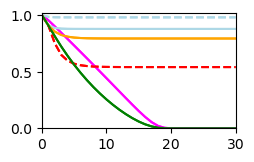

In [19]:
#Plot
f1 = PyPlot.figure(figsize=(2.5,1.5))
col_vec = ["#FF9933","#336699"]

i=1
for output in output_vec
    PyPlot.plot(0:t,PDNE_output_vec[i]["relative_number_females"].adult,color = "magenta","-",label="PDNE")  
    PyPlot.plot(0:t,SIT_output_vec[i]["relative_number_females"].adult,color = "lightblue","--",label="SIT")  
    PyPlot.plot(0:t,RIDL_output_vec[i]["relative_number_females"].adult,color = "lightblue","-",label="RIDL")  
    PyPlot.plot(0:t,fsRIDL_output_vec[i]["relative_number_females"].adult,color = "orange","-",label="fsRIDL")  
    PyPlot.plot(0:t,XS_output_vec[i]["relative_number_females"].adult,color = "red","--",label="XS")
    PyPlot.plot(0:t,MDFS_output_vec[i]["relative_number_females"].adult,color = "green","-",label="MDFS")
end

PyPlot.xlim(0,30)
PyPlot.ylim(0,1.02)

PyPlot.show()

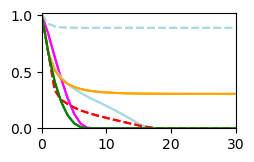

In [20]:
#Plot
f1 = PyPlot.figure(figsize=(2.5,1.5))
col_vec = ["#FF9933","#336699"]

i=2
for output in output_vec
    PyPlot.plot(0:t,PDNE_output_vec[i]["relative_number_females"].adult,color = "magenta","-",label="PDNE")  
    PyPlot.plot(0:t,SIT_output_vec[i]["relative_number_females"].adult,color = "lightblue","--",label="SIT")  
    PyPlot.plot(0:t,RIDL_output_vec[i]["relative_number_females"].adult,color = "lightblue","-",label="RIDL")  
    PyPlot.plot(0:t,fsRIDL_output_vec[i]["relative_number_females"].adult,color = "orange","-",label="fsRIDL")  
    PyPlot.plot(0:t,XS_output_vec[i]["relative_number_females"].adult,color = "red","--",label="XS")
    PyPlot.plot(0:t,MDFS_output_vec[i]["relative_number_females"].adult,color = "green","-",label="MDFS")
end

PyPlot.xlim(0,30)
PyPlot.ylim(0,1.02)

PyPlot.show()

### Figure 3 and Supplementaty Figure 1

In [21]:
#Define parameter sweep range
Rm_vec = collect(2:20);
n_releases = collect(1:36);


In [22]:
#PDNE
for thrld in [0.01,0.05,0.33]
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            PDNE_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A1" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/PDNE_$thrld.jld2" lab_rrr;
end;

In [23]:
#SIT

for thrld in [0.01,0.05,0.33]
    n_releases = collect(1:36)
    Rms = collect(2:20)
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            SIT_pdict,
                                            inputs_SIT;
                                            t=n_release,
                                            release_genotype=["A2" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/SIT_$thrld.jld2" lab_rrr;
end;

In [24]:
#RIDL
for thrld in [0.01,0.05,0.33]
    n_releases = collect(1:36)
    Rms = collect(2:20)
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            RIDL_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A2" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/RIDL_$thrld.jld2" lab_rrr;
end;

In [25]:
#fsRIDL
for thrld in [0.01,0.05,0.33]
    n_releases = collect(1:36)
    Rms = collect(2:20)
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            fsRIDL_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A2" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/fsRIDL_$thrld.jld2" lab_rrr;
end;

In [26]:
#XS
for thrld in [0.01,0.05,0.33]
    n_releases = collect(1:36)
    Rms = collect(2:20)
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            XS_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A2" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/XS_$thrld.jld2" lab_rrr;
end;

In [27]:
#MDFS
for thrld in [0.01,0.05,0.33]
    n_releases = collect(1:36)
    Rms = collect(2:20)
    lab_rrr = zeros(length(n_releases),length(Rm_vec))
    row=0
    for n_release in n_releases 
        row = row+1
        col=0
        for Rm in Rm_vec
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            MDFS_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A1" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
    @save "./results/SingleLocus/MDFS_$thrld.jld2" lab_rrr;
end;

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


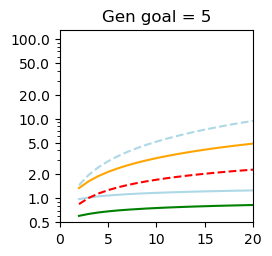

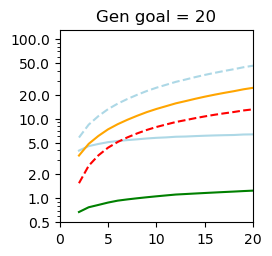

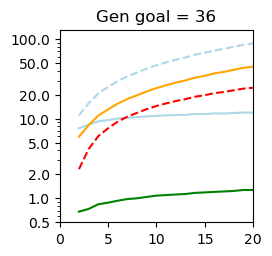

In [28]:
#Plot rrr for 99% suppression
@load "./results/SingleLocus/SIT_0.01.jld2"
SIT_rrr = lab_rrr

@load "./results/SingleLocus/RIDL_0.01.jld2"
RIDL_rrr = lab_rrr

@load "./results/SingleLocus/fsRIDL_0.01.jld2"
fsRIDL_rrr = lab_rrr

@load "./results/SingleLocus/XS_0.01.jld2"
XS_rrr = lab_rrr

@load "./results/SingleLocus/MDFS_0.01.jld2"
MDFS_rrr = lab_rrr

@load "./results/SingleLocus/PDNE_0.01.jld2"
PDNE_rrr = lab_rrr;

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 5


y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 5")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 20

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 20")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 36

#PyPlot.plot([0,20],[1,1],color = "grey",":",alpha=0.5) 

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 36")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


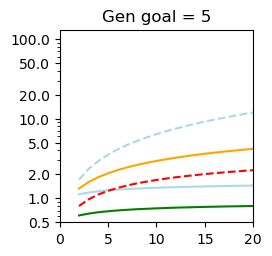

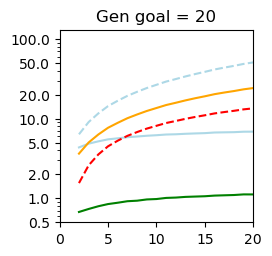

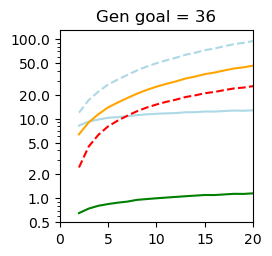

In [29]:
#Plot rrr for 95% suppression
@load "./results/SingleLocus/SIT_0.05.jld2"
SIT_rrr = lab_rrr

@load "./results/SingleLocus/RIDL_0.05.jld2"
RIDL_rrr = lab_rrr

@load "./results/SingleLocus/fsRIDL_0.05.jld2"
fsRIDL_rrr = lab_rrr

@load "./results/SingleLocus/XS_0.05.jld2"
XS_rrr = lab_rrr

@load "./results/SingleLocus/MDFS_0.05.jld2"
MDFS_rrr = lab_rrr

@load "./results/SingleLocus/PDNE_0.05.jld2"
PDNE_rrr = lab_rrr;

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 5

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 5")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 20

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 20")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

#plot repeat releases of the above release rate to check
f1 = PyPlot.figure(figsize=(2.5,2.5))

Gen_index = 36

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
#PyPlot.ylim(0,60)
PyPlot.title("Gen goal = 36")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])

PyPlot.show()

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


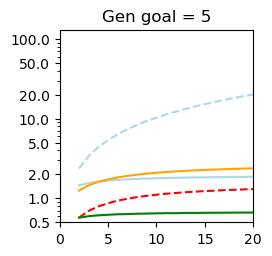

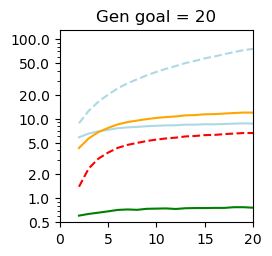

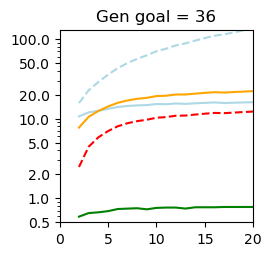

In [30]:
#Plot rrr for 66% suppression
@load "./results/SingleLocus/SIT_0.33.jld2"
SIT_rrr = lab_rrr

@load "./results/SingleLocus/RIDL_0.33.jld2"
RIDL_rrr = lab_rrr

@load "./results/SingleLocus/fsRIDL_0.33.jld2"
fsRIDL_rrr = lab_rrr

@load "./results/SingleLocus/XS_0.33.jld2"
XS_rrr = lab_rrr

@load "./results/SingleLocus/MDFS_0.33.jld2"
MDFS_rrr = lab_rrr

@load "./results/SingleLocus/PDNE_0.33.jld2"
PDNE_rrr = lab_rrr;

Gen_index = 5
f1 = PyPlot.figure(figsize=(2.5,2.5))

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
PyPlot.title("Gen goal = 5")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])
PyPlot.show()

Gen_index = 20
f1 = PyPlot.figure(figsize=(2.5,2.5))

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
PyPlot.title("Gen goal = 20")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])
PyPlot.show()

Gen_index = 36
f1 = PyPlot.figure(figsize=(2.5,2.5))

y = SIT_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

y = RIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

y = fsRIDL_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

y = XS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

y = MDFS_rrr ./  PDNE_rrr
PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

PyPlot.xlim(0,20)
PyPlot.yscale("log")
PyPlot.ylim(0.6,130)
PyPlot.title("Gen goal = 36")
PyPlot.yticks([0.50,1,2,5,10,20,50,100],[0.50,1,2,5,10,20,50,100])
PyPlot.show()

### Table 1

In [33]:
row=0
lab_rrr = zeros(6,3)
for n_release in [36,5]
    for thrld in [0.33,0.05,0.01]
        row = row+1
        col=0
        for Rm in [2,6,20]
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            PDNE_pdict,
                                            inputs;
                                            t=n_release,
                                            release_genotype=["A1" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
end;
PDNE_lab_rrr = lab_rrr

6×3 Matrix{Float64}:
 0.017  0.03   0.036
 0.023  0.042  0.052
 0.025  0.044  0.056
 0.217  0.303  0.344
 0.481  0.685  0.819
 0.693  0.992  1.228

In [34]:
row=0
lab_rrr = zeros(6,3)
for n_release in [36,5]
    for thrld in [0.33,0.05,0.01]
        row = row+1
        col=0
        for Rm in [2,6,20]
            col=col+1
            rr = find_release_rate_required(n_release,
                                            0.0,
                                            thrld,
                                            SIT_pdict,
                                            inputs_SIT;
                                            t=n_release,
                                            release_genotype=["A2" "A2"],
                                            Rm = Rm)
            lab_rrr[row,col]=rr
        end
    end
end;
SIT_lab_rrr = lab_rrr

6×3 Matrix{Float64}:
 0.266  1.286   4.858
 0.273  1.297   4.892
 0.274  1.3     4.899
 0.511  1.929   6.912
 0.823  2.809   9.773
 1.012  3.342  11.51

In [35]:
#Fold difference
round.(SIT_lab_rrr./PDNE_lab_rrr,digits=0)

6×3 Matrix{Float64}:
 16.0  43.0  135.0
 12.0  31.0   94.0
 11.0  30.0   87.0
  2.0   6.0   20.0
  2.0   4.0   12.0
  1.0   3.0    9.0

### Figure 4a-d

##### a) Editing rate

In [36]:
#bisex PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[c]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/c_Rmvar.jld2" rr_output

In [37]:
#fs PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[c,
            srm,
            sgrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,0.0,0.0],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/c_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


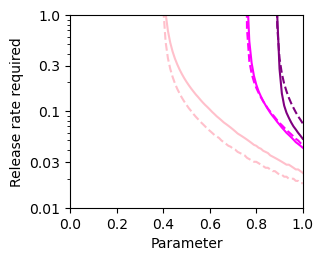

In [48]:
#plot
colours = ["pink","magenta","purple"]

f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/SingleLocus/c_Rmvar.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="-")  
end

@load "./results/SingleLocus/c_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--")  
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()

##### b) Homozygous fitness cost of edit

In [39]:
#bisex PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[srf,srm,sgrf,sgrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod,param_mod,param_mod],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/srf_srm_Rmvar.jld2" rr_output

In [40]:
#fs PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[srf,
            sgrf,
            srm,
            sgrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod,0.0,0.0],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/srf_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


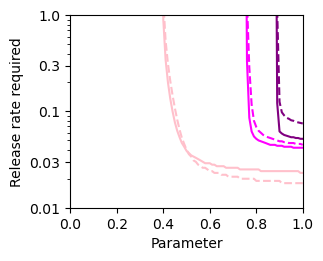

In [41]:
#plot
styles = ["--","--","--","-","-","-"]
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/SingleLocus/srf_srm_Rmvar.jld2"
#Bisex
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="-",label="a")  
end
#Female specific
@load "./results/SingleLocus/srf_Rmvar_fs.jld2"

for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--",label="a")  
end

PyPlot.xlim(0,maximum(param_mod_list))
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


##### c) Heterozygous fitness cost of edit

In [42]:
#bisex PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[hrf,hrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/hr_Rmvar.jld2" rr_output

In [43]:
#fs PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[hrf,
            hrm,
            srm,
            sgrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod,0.0,0.0],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/hr_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


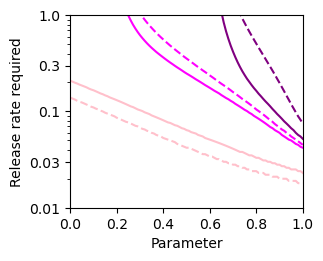

In [44]:
#plot
styles = ["-","-","-"]
param_mod_list = collect(0.0:0.01:1.0)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/SingleLocus/hr_Rmvar.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle=styles[i])  
end

@load "./results/SingleLocus/hr_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--")  
end

PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])
PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


##### d) Heterozygous fitness cost of construct

In [45]:
#bisex PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[hgf,hgm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/hg_Rmvar.jld2" rr_output

In [46]:
#fs PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[hgf,
            hgm,
            srm,
            sgrm]
param_mod_list = collect(0.0:0.01:1.0)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,param_mod,0.0,0.0],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocus/hg_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


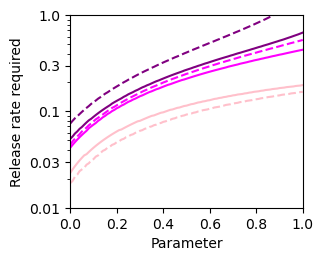

In [47]:
#plot
styles = ["-","-","-"]
param_mod_list = collect(0.0:0.01:1.0)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/SingleLocus/hg_Rmvar.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle=styles[i])  
end

@load "./results/SingleLocus/hg_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--")  
end

PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


## Single locus model with loss of function mutations

### Load in gamete and fitness tables

Allele labels 

A1 = W

A2 = G = construct

A3 = G_1 = construct without Cas9

A4 = G_2 = construct without gRNA

A5 = G_3 = construct without Cas9 or gRNA

A6 = R = edit

In [5]:
#Define all alleles and genotypes 
loci=["A"]
alleles = [["A1"],["A2"],["A3"],["A4"],["A5"],["A6"]];
genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [6]:
#Load in gamete and fitness tables
sgf, hgf, srf, hrf, sgrf,sgm, hgm, srm, hrm, sgrm, c, j, pj, d = Sym("sgf hgf srf hrf sgrf sgm hgm srm hrm sgrm c j pj d")

genotypes_f_string = [string(genotypes_f[i][1]*genotypes_f[i][2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1]*genotypes_m[i][2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./PDNE_LOF/PDNE_LOF_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./PDNE_LOF/PDNE_LOF_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./PDNE_LOF/PDNE_LOF_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./PDNE_LOF/PDNE_LOF_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);


In [7]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

### Figure 4e

In [8]:
#Define PDNE
release_genotype= ["A1" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=1.0
pdict[hgm]=0.0
pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sgrm]=1.0
pdict[c]=1.0
pdict[d]=0.01

PDNE_pdict = pdict

PDNE_subs_list = [(p,pdict[p]) for p in keys(pdict)];

In [9]:
#bisex PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[d]
param_mod_list = collect(0.0:0.0025:0.3)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1
        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocusLOF/d_Rmvar.jld2" rr_output

In [10]:
#fs PDNE
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
loci = ["A"]
fitness_A = "a"
param_label=[d,
            srm,
            sgrm]
param_mod_list = collect(0.0:0.0025:0.3)
rr_output = Array{Float64}(undef,(length(Rm_vec),length(param_mod_list)));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    for param_mod in param_mod_list
        n=n+1

        rr = find_release_rate_required(n_releases,
                                            0.0,
                                            threshold,
                                            PDNE_pdict,
                                            inputs;
                                            release_genotype=["A1" "A2"],
                                            param_mod=[param_mod,0.0,0.0],
                                            param_label=param_label,
                                            t=n_releases,
                                            Rm = Rm)
        
        rr_output[count_,n]=rr
    end
end
@save "./results/SingleLocusLOF/d_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


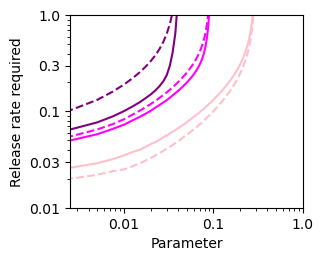

In [11]:
#plot
colours = ["pink","magenta","purple","pink","magenta","purple"]
styles = ["-","-","-"]
param_mod_list = collect(0.0:0.0025:0.3)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/SingleLocusLOF/d_Rmvar.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle=styles[i])  
end

@load "./results/SingleLocusLOF/d_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--")  
end

PyPlot.xlim(0,0.3)
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.xscale("log")
PyPlot.xlim(0,1)
PyPlot.xticks([0.01,0.1,1],[0.01,0.1,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()

### Supplementary Figure 2

In [ ]:
#PDNE repeat release time series
release_genotype= ["A1" "A2"]
fitness_effect = "a"

# Define inheritance and fitness params
pdict = Dict()
pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0
pdict[sgm]=1.0
pdict[hgm]=0.0
pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sgrm]=1.0
pdict[c]=1.0
pdict[d]=0.01
PDNE_pdict = pdict

PDNE_subs_list = [(p,pdict[p]) for p in keys(pdict)];

##### a) Single 100% release

In [69]:
#Simulate
t=300
release_freq = 1.0
release_regime = false
output = Simulate_single_release_example(PDNE_subs_list,
                                                inputs,
                                                t,
                                                release_freq,
                                                release_genotype);


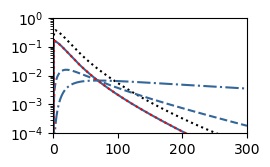

In [70]:
#plot
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,1 .-output["relative_number_females"].adult,color = "black",":", label ="Relative reduction in no. females")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "#336699","-",label="PDNE")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A4,color = "#336699","--",label="PDNE-Cas9 or PDNE-Cas9")
PyPlot.plot(0:t,output["allelefreq_zygote"].A5,color = "#336699","-.",label="PDNE-Cas9-gRNA")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A6,color = "red",":",label="Dominant Edit")  

PyPlot.xlim(0,t)
PyPlot.ylim(0,1.02)

PyPlot.yscale("log")
PyPlot.ylim(0.0001,1)

PyPlot.show()


##### b) Repeat 5% release

In [78]:
#Simulate
t=60
release_freq = 0.05
n_releases = t
release_regime = repeat([0.0],t);
for i in 1:n_releases
    release_regime[i] = release_freq
end
output = Simulate_single_release_example(PDNE_subs_list,
                                        t,
                                        release_freq,
                                        release_genotype,
                                        fitness_effect=fitness_effect,
                                        release_regime=release_regime);

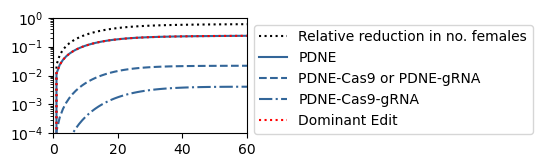

In [80]:
#plot
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,1 .-output["relative_number_females"].adult,color = "black",":", label ="Relative reduction in no. females")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "#336699","-",label="PDNE")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A4,color = "#336699","--",label="PDNE-Cas9 or PDNE-gRNA")
PyPlot.plot(0:t,output["allelefreq_zygote"].A5,color = "#336699","-.",label="PDNE-Cas9-gRNA")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A6,color = "red",":",label="Dominant Edit")  

PyPlot.xlim(0,t)
PyPlot.ylim(0,1.02)

PyPlot.legend(bbox_to_anchor=(1, 1))
PyPlot.yscale("log")
PyPlot.ylim(0.0001,1)

PyPlot.show()


## 2-locus model

### Load in gamete and fitness tables

Allele labels:

Locus 1

A1 = W

A2 - G = construct

Locus 2

B1 = W

B2 = R = edit

In [5]:
#Define all alleles and genotypes 
loci = ["A","B"]

alleles = [["A1", "B1"],
            ["A1", "B2"],
            ["A2", "B1"],
            ["A2", "B2"]]

genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [6]:
#Load in gamete and fitness tables
a_sgf, a_hgf, a_srf, a_hrf, a_sgm, a_hgm, a_srm, a_hrm, c, j, u, r = Sym("a_sgf a_hgf a_srf a_hrf a_sgm a_hgm a_srm a_hrm c j u r")
b_sgf, b_hgf, b_srf, b_hrf, b_sgm, b_hgm, b_srm, b_hrm = Sym("b_sgf b_hgf b_srf b_hrf b_sgm b_hgm b_srm b_hrm")
s_sgf, s_hgf, s_srf, s_hrf, s_sgm, s_hgm, s_srm, s_hrm = Sym("s_sgf s_hgf s_srf s_hrf s_sgm s_hgm s_srm s_hrm")
#Read in genotypes from storage
genotypes_f_string = [string(genotypes_f[i][1,1]*genotypes_f[i][2,1]*genotypes_f[i][1,2]*genotypes_f[i][2,2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1,1]*genotypes_m[i][2,1]*genotypes_m[i][1,2]*genotypes_m[i][2,2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./Two_locus/Two_locus_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./Two_locus/Two_locus_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./Two_locus/Two_locus_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./Two_locus/Two_locus_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

In [7]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

### Supplementary Figure 5

In [8]:
pdict = Dict()
    
pdict[c]=1.0
pdict[j]=0.0
pdict[u]=1.0

pdict[a_sgf]=0.0
pdict[a_hgf]=0.0
pdict[a_sgm]=0.0
pdict[a_hgm]=0.0
pdict[b_sgf]=0.0
pdict[b_hgf]=0.0
pdict[b_sgm]=0.0
pdict[b_hgm]=0.0
pdict[s_sgf]=0.0
pdict[s_hgf]=0.0
pdict[s_sgm]=0.0
pdict[s_hgm]=0.0
pdict[a_srm]=0.0
pdict[a_hrm]=0.0
pdict[a_srf]=0.0
pdict[a_hrf]=0.0
pdict[b_srm]=0.0
pdict[b_hrm]=0.0
pdict[b_srf]=0.0
pdict[b_hrf]=0.0
pdict[s_srm]=0.0
pdict[s_hrm]=0.0
pdict[s_srf]=0.0
pdict[s_hrf]=0.0

pdict[r] = 0.0

0.0

In [9]:
#code
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_types = ["a","s","b"]
rr_output = Array{Float64}(undef,(length(Rm_vec),length(fitness_types)^2));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    
    for fitness_2 in fitness_types
        for fitness in fitness_types
            
            # Define inheritance and fitness params
            Two_locus_pdict = deepcopy(pdict)
            
            if fitness == "a"
                Two_locus_pdict[a_sgf]=1.0
                Two_locus_pdict[a_hgf]=0.0
                Two_locus_pdict[a_sgm]=1.0
                Two_locus_pdict[a_hgm]=0.0
            elseif fitness == "b"
                Two_locus_pdict[b_sgf]=1.0
                Two_locus_pdict[b_hgf]=0.0
                Two_locus_pdict[b_sgm]=1.0
                Two_locus_pdict[b_hgm]=0.0
            elseif fitness == "s"
                Two_locus_pdict[s_sgf]=1.0
                Two_locus_pdict[s_hgf]=0.0
                Two_locus_pdict[s_sgm]=1.0
                Two_locus_pdict[s_hgm]=0.0
            end
            
            if fitness_2 == "a"
                Two_locus_pdict[a_srm]=1.0
                Two_locus_pdict[a_hrm]=1.0
                Two_locus_pdict[a_srf]=1.0
                Two_locus_pdict[a_hrf]=1.0
            elseif fitness_2 == "b"
                Two_locus_pdict[b_srm]=1.0
                Two_locus_pdict[b_hrm]=1.0
                Two_locus_pdict[b_srf]=1.0
                Two_locus_pdict[b_hrf]=1.0
            elseif fitness_2 == "s"
                Two_locus_pdict[s_srm]=1.0
                Two_locus_pdict[s_hrm]=1.0
                Two_locus_pdict[s_srf]=1.0
                Two_locus_pdict[s_hrf]=1.0
            end

            n=n+1 
            rr = find_release_rate_required(n_releases,
                                        0.0,
                                        threshold,
                                        Two_locus_pdict,
                                        inputs,
                                        release_genotype=["A1" "A2"; "B1" "B1"],
                                        t=n_releases,
                                        Rm = Rm)

            rr_output[count_,n]=rr
            
        end
    end
end
@save "./results/TwoLocus/fitness_type_Rmvar.jld2" rr_output

In [10]:
#code
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_types = ["a","s","b"]
rr_output = Array{Float64}(undef,(length(Rm_vec),length(fitness_types)^2));
count_ = 0
for Rm in Rm_vec
    count_ = count_+1
    n=0
    
    for fitness_2 in fitness_types
        for fitness in fitness_types
            
            # Define inheritance and fitness params
            Two_locus_pdict = deepcopy(pdict)
            
            if fitness == "a"
                Two_locus_pdict[a_sgf]=1.0
                Two_locus_pdict[a_hgf]=0.0
                Two_locus_pdict[a_sgm]=1.0
                Two_locus_pdict[a_hgm]=0.0
            elseif fitness == "b"
                Two_locus_pdict[b_sgf]=1.0
                Two_locus_pdict[b_hgf]=0.0
                Two_locus_pdict[b_sgm]=1.0
                Two_locus_pdict[b_hgm]=0.0
            elseif fitness == "s"
                Two_locus_pdict[s_sgf]=1.0
                Two_locus_pdict[s_hgf]=0.0
                Two_locus_pdict[s_sgm]=1.0
                Two_locus_pdict[s_hgm]=0.0
            end
            
            if fitness_2 == "a"
                Two_locus_pdict[a_srf]=1.0
                Two_locus_pdict[a_hrf]=1.0
            elseif fitness_2 == "b"
                Two_locus_pdict[b_srf]=1.0
                Two_locus_pdict[b_hrf]=1.0
            elseif fitness_2 == "s"
                Two_locus_pdict[s_srf]=1.0
                Two_locus_pdict[s_hrf]=1.0
            end

            Two_locus_subs_list = [(p,Two_locus_pdict[p]) for p in keys(Two_locus_pdict)];

            n=n+1 
            rr = find_release_rate_required(n_releases,
                                        0.0,
                                        threshold,
                                        Two_locus_pdict,
                                        inputs,
                                        release_genotype=["A1" "A2"; "B1" "B1"],
                                        t=n_releases,
                                        Rm = Rm)

            rr_output[count_,n]=rr
            
        end
    end
end
@save "./results/TwoLocus/fitness_type_Rmvar_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


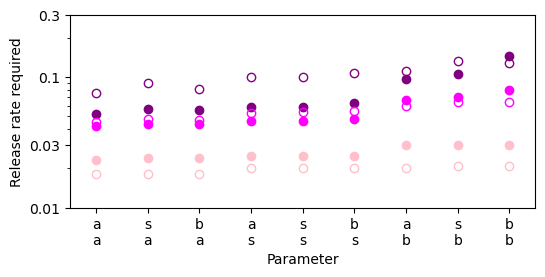

In [11]:
#plot
fitness_types = ["a","s","b"]
colours = ["pink","magenta","purple","pink","magenta","purple"]
fitness_type_labels = [j*"\n"*i for i in fitness_types for j in fitness_types]

f1 = PyPlot.figure(figsize=(6,2.5))

@load "./results/TwoLocus/fitness_type_Rmvar.jld2"
for i in 1:3
    PyPlot.plot(1:length(fitness_types)^2,
        rr_output[i,:],
        color =colours[i], 
        marker = "o",
        fillstyle = "full",
        linestyle = "none",
        label="x")
end
            
@load "./results/TwoLocus/fitness_type_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(1:length(fitness_types)^2,
        rr_output[i,:],
        color =colours[i], 
        marker = "o",
        fillstyle = "none",
        linestyle = "none",
        label="x")
end
      

PyPlot.xlim(0.5,length(fitness_type_labels)+0.5)
PyPlot.yscale("log")
PyPlot.ylim(0.01,0.3)
PyPlot.yticks([0.01,0.03,0.1,0.3],[0.01,0.03,0.1,0.3])
PyPlot.xticks(1:length(fitness_type_labels),fitness_type_labels)

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


### Supplementary Figure 6

In [12]:
#Params
pdict = Dict()
    
pdict[c]=1.0
pdict[j]=0.0
pdict[u]=1.0

pdict[a_sgf]=1.0
pdict[a_hgf]=0.0
pdict[a_sgm]=1.0
pdict[a_hgm]=0.0
pdict[a_srm]=1.0
pdict[a_hrm]=1.0
pdict[a_srf]=1.0
pdict[a_hrf]=1.0

pdict[b_sgf]=0.0
pdict[b_hgf]=0.0
pdict[b_sgm]=0.0
pdict[b_hgm]=0.0
pdict[s_sgf]=0.0
pdict[s_hgf]=0.0
pdict[s_sgm]=0.0
pdict[s_hgm]=0.0
pdict[b_srm]=0.0
pdict[b_hrm]=0.0
pdict[b_srf]=0.0
pdict[b_hrf]=0.0
pdict[s_srm]=0.0
pdict[s_hrm]=0.0
pdict[s_srf]=0.0
pdict[s_hrf]=0.0

pdict[r] = 0.0;

In [13]:
#code - 2 locus rm6
threshold = 0.05
n_releases = 36
param_label=[r,c,u]

Rm=6

param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.7:0.1:1.0)

index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end

@save "./results/TwoLocus/r_cmuvar_rm6.jld2" rr_output

In [14]:
#code - 2 locus rm6 fs
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_A = "a"
param_label=[r,c,u,a_srm]
Rm=6
param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.7:0.1:1.0)

index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2,0.0],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end


@save "./results/TwoLocus/r_cmuvar_rm6_fs.jld2" rr_output

In [15]:
#code - 2 locus rm2
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_A = "a"
param_label=[r,c,u]
Rm=2
param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.3:0.1:1.0)

index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end


@save "./results/TwoLocus/r_cmuvar_rm2.jld2" rr_output

In [16]:
#code - 2 locus rm2 fs
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_A = "a"
param_label=[r,c,u,a_srm]
Rm=2
param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.3:0.1:1.0)

index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2,0.0],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end


@save "./results/TwoLocus/r_cmuvar_rm2_fs.jld2" rr_output

In [17]:
#code - 2 locus rm20
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_A = "a"
param_label=[r,c,u]
Rm=20
param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.8:0.1:1.0)


index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end


@save "./results/TwoLocus/r_cmuvar_rm20.jld2" rr_output

In [18]:
#code - 2 locus rm20 fs
threshold = 0.05
Rm_vec = [2,6,20]
n_releases = 36
fitness_A = "a"
param_label=[r,c,u,a_srm]
Rm=20
param_mod_list = collect(0.0:0.05:0.5)
param_mod_list_b = collect(0.8:0.1:1.0)

index_vec = []
for i in 1:length(param_mod_list_b)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(param_mod_list_b),length(param_mod_list));
for n in index_vec
    i,k =n
    param_mod = param_mod_list[k]
    param_mod2 = param_mod_list_b[i]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B1"],
        param_mod=[param_mod,param_mod2,param_mod2,0.0],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end


@save "./results/TwoLocus/r_cmuvar_rm20_fs.jld2" rr_output

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


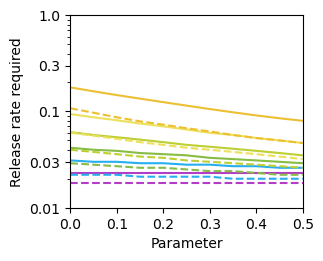

In [19]:
#plot rm2
param_mod_list_b = collect(0.3:0.1:1.0)
colours = ["#f46a9b", "#ef9b20", "#edbf33", "#ede15b", "#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]
param_mod_list = collect(0.0:0.05:0.5)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/TwoLocus/r_cmuvar_rm2.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color = colours[i],label=param_mod_list_b[i])  
end

@load "./results/TwoLocus/r_cmuvar_rm2_fs.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],linestyle="--",
        color = colours[i])  
end


PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


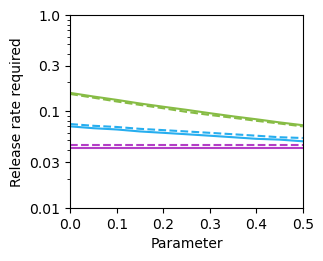

In [20]:
#plot rm 6
param_mod_list_b = collect(0.7:0.1:1.0)

colours = ["#bdcf32", "#87bc45", "#27aeef", "#b33dc6"]
param_mod_list = collect(0.0:0.05:0.5)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/TwoLocus/r_cmuvar_rm6.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],color=colours[i])  
end
@load "./results/TwoLocus/r_cmuvar_rm6_fs.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],linestyle="--",color=colours[i])  
end

PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


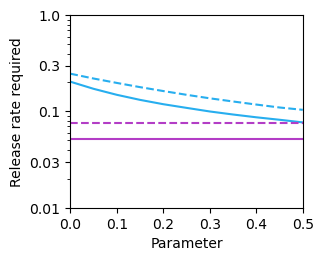

In [21]:
#plot rm20
param_mod_list_b = collect(0.8:0.1:1.0)

colours = ["#87bc45", "#27aeef", "#b33dc6"]
param_mod_list = collect(0.0:0.05:0.5)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/TwoLocus/r_cmuvar_rm20.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],color=colours[i])  
end
@load "./results/TwoLocus/r_cmuvar_rm20_fs.jld2"
for i in 1:length(param_mod_list_b)
    PyPlot.plot(param_mod_list,
        rr_output[i,:],linestyle="--",color=colours[i])  
end

PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()


## 2-locus model without rescue

### Load in gamete and fitness tables

Locus 1

A1 = W

A2 - G = Construct

Locus 2

B1 = W

B2 = R = Edit

B3 = I = Immune to editing

In [5]:
#Define all alleles and genotypes 
loci = ["A","B"]

alleles = [["A1", "B1"],
            ["A1", "B2"],
            ["A1", "B3"],
            ["A2", "B1"],
            ["A2", "B2"],
            ["A2", "B3"]]

genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [6]:
#Define symbols (don't change)
sgf, hgf, srf, hrf, sirf, sgm, hgm, srm, hrm, sirm, him,sim,hif,sif, c, j, u, r = Sym("sgf hgf srf hrf sirf sgm hgm srm hrm sirm him sim hif sif c j u r")

#Read in genotypes from storage
genotypes_f_string = [string(genotypes_f[i][1,1]*genotypes_f[i][2,1]*genotypes_f[i][1,2]*genotypes_f[i][2,2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1,1]*genotypes_m[i][2,1]*genotypes_m[i][1,2]*genotypes_m[i][2,2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./Two_locus_norescue/Two_locus_norescue_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./Two_locus_norescue/Two_locus_norescue_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./Two_locus_norescue/Two_locus_norescue_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./Two_locus_norescue/Two_locus_norescue_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

In [7]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

### Supplementary Figure 7

In [8]:
pdict = Dict()
    
pdict[c]=1.0
pdict[j]=1.0
pdict[u]=1.0

pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[sgm]=1.0
pdict[hgm]=0.0

pdict[srm]=1.0
pdict[hrm]=1.0
pdict[sim]=0.0
pdict[him]=0.0
pdict[sirm]=1.0

pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sif]=0.0
pdict[hif]=0.0
pdict[sirf]=1.0

pdict[r] = 0.0

0.0

In [9]:
#code - 2 locus rm6
threshold = 0.05
n_releases = 36
param_label=[r]
Rm_vec = [2,6,20]

param_mod_list = collect(0.0:0.0025:0.2)
index_vec = []
for i in 1:length(Rm_vec)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(Rm_vec),length(param_mod_list));
for n in index_vec
    i,k =n
    Rm = Rm_vec[i]
    param_mod = param_mod_list[k]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B2"],
        param_mod=param_mod,
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end

@save "./results/TwoLocusNoRsc/r_zoomed_Rmvar.jld2" rr_output

In [12]:
#code - 2 locus rm6
threshold = 0.05
n_releases = 36
param_label=[r,srm]
Rm_vec = [2,6,20]

param_mod_list = collect(0.0:0.0025:0.2)
index_vec = []
for i in 1:length(Rm_vec)
    for k in 1:length(param_mod_list)
        push!(index_vec,[i,k])
    end
end

rr_output = Array{Float64}(undef,length(Rm_vec),length(param_mod_list));
for n in index_vec
    i,k =n
    Rm = Rm_vec[i]
    param_mod = param_mod_list[k]
    rr=find_release_rate_required(
        n_releases,
        0.0,
        threshold,
        pdict,
        inputs;
        release_genotype=["A1" "A2"; "B1" "B2"],
        param_mod=[param_mod,0.0],
        param_label=param_label,
        t=n_releases,
        Rm=Rm)
    rr_output[i,k]=rr
end

@save "./results/TwoLocusNoRsc/r_zoomed_Rmvar_fs.jld2" rr_output

0.023
0.042
0.052000000000000005


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


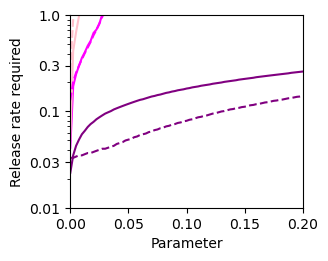

In [13]:
#plot
colours = ["purple","magenta","pink"]
styles = ["-","-","-"]
param_mod_list = collect(0.0:0.0025:0.2)
f1 = PyPlot.figure(figsize=(3,2.5))

@load "./results/TwoLocusNoRsc/r_zoomed_Rmvar.jld2"
for i in 1:3
    println(rr_output[i,1])
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle=styles[i])  
end

@load "./results/TwoLocusNoRsc/r_zoomed_Rmvar_fs.jld2"
for i in 1:3
    PyPlot.plot(param_mod_list,
        rr_output[i,:],
        color =colours[i], 
        linestyle="--")  
end

PyPlot.xlim(0,maximum(param_mod_list))
    
        
PyPlot.yscale("log")
PyPlot.ylim(0.018,1)
PyPlot.yticks([0.01,0.03,0.1,0.3,1],[0.01,0.03,0.1,0.3,1])

PyPlot.ylabel("Release rate required")
PyPlot.xlabel("Parameter")

PyPlot.show()

## Homing booster model

### Load in gamete and fitness tables

Locus 1

A1 = W

A2 = B = Booster

Locus 2

B1 = W

B2 = G = Editor

Locus 3

C1 = W

C2 = R = Edit

In [5]:
#Define all alleles and genotypes 
loci= ["A","B","C"]
alleles = [["A1", "B1", "C1"],
         ["A1", "B1", "C2"],
         ["A1", "B2", "C1"],
         ["A1", "B2", "C2"],
         ["A2", "B1", "C1"],
         ["A2", "B1", "C2"],
         ["A2", "B2", "C1"],
         ["A2", "B2", "C2"]]

genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [6]:
#Define symbols (don't change)
sgf, hgf, srf, hrf, sgm, hgm, srm, hrm, cH, c,r1,r2,m = Sym("sgf hgf srf hrf sgm hgm srm hrm cH c r1 r2 m")

#Read in genotypes from storage
genotypes_f_string = [string(genotypes_f[i][1,1]*genotypes_f[i][2,1]*genotypes_f[i][1,2]*genotypes_f[i][2,2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1,1]*genotypes_m[i][2,1]*genotypes_m[i][1,2]*genotypes_m[i][2,2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./Homing_booster/Homing_booster_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./Homing_booster/Homing_booster_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./Homing_booster/Homing_booster_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./Homing_booster/Homing_booster_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

In [7]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

### Figure 5a and b

In [8]:
Rm=6

#Homing booster setup
pdict = Dict()

#PDNE at the B locus
pdict[cH]=1.0

pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[sgm]=1.0
pdict[hgm]=0.0

pdict[srf]=1.0
pdict[hrf]=1.0
pdict[srm]=0.0
pdict[hrm]=0.0

#HI at the C locus
pdict[c]=1.0

pdict[r1]=0.5
pdict[r2]=0.0

pdict[m]=0.5

0.5

In [23]:
#Dynamics params
params = Dict()
Nf_eq = 1000.0
params["OJ"] = 1/10
params["f"] = (2*Rm)/params["OJ"]
params["α"] = params["f"]*Nf_eq/(Rm-1)

opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);


In [24]:
#Simulate
t=20
release_genotype = ["A1" "A1"; "B1" "B2"; "C1" "C1"]
release_freq=1.0

#Set up release
starting_population_Nf,starting_population_Nm = Initiate_prerelease_population_4lifestages(params, genotypes_m,genotypes_f)
starting_population_post_release_m = release_transgenic_males(starting_population_Nm,release_genotype,release_freq,genotypes_m)
starting_population_post_release = [starting_population_Nf,starting_population_post_release_m]

output = Simulate_timeseries(t,             #number of generations
                            starting_population_post_release, #[1] = female, [2] = male
                            genotypes_m,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]
                            genotypes_f,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]) 
                            ic_f_vals,
                            ic_m_vals,
                            fitness_f_vals,
                            fitness_m_vals,
                            params)
        
output = Simulation_processing_wrapper(output,falleles,malleles,genotypes_f,genotypes_m);

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


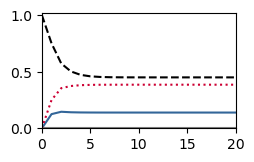

In [25]:
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,output["relative_number_females"].adult,color = "k","--")  
PyPlot.plot(0:t,output["allelefreq_zygote"].B2,color = "#336699","-")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "grey","-")   
PyPlot.plot(0:t,output["allelefreq_zygote"].C2,color = "#CC0033",":")   

PyPlot.xlim(0,20)
PyPlot.ylim(0,1.02)

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.show()

In [26]:
#Simulate
t=20
release_genotype = ["A1" "A2"; "B1" "B2"; "C1" "C1"]
release_freq=1.0

#Set up release
starting_population_Nf,starting_population_Nm = Initiate_prerelease_population_4lifestages(params, genotypes_m,genotypes_f)
starting_population_post_release_m = release_transgenic_males(starting_population_Nm,release_genotype,release_freq,genotypes_m)
starting_population_post_release = [starting_population_Nf,starting_population_post_release_m]

output = Simulate_timeseries(t,             #number of generations
                            starting_population_post_release, #[1] = female, [2] = male
                            genotypes_m,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]
                            genotypes_f,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]) 
                            ic_f_vals,
                            ic_m_vals,
                            fitness_f_vals,
                            fitness_m_vals,
                            params)
        
output = Simulation_processing_wrapper(output,falleles,malleles,genotypes_f,genotypes_m);

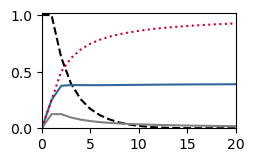

In [27]:
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,output["relative_number_females"].adult,color = "k","--")  
PyPlot.plot(0:t,output["allelefreq_zygote"].B2,color = "#336699","-")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "grey","-")   
PyPlot.plot(0:t,output["allelefreq_zygote"].C2,color = "#CC0033",":")   

PyPlot.xlim(0,20)
PyPlot.ylim(0,1.02)

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.show()

In [28]:
#Simulate - testing tight linkage between the booster and construct
pdict[r1]=0.0

t=20
release_genotype = ["A1" "A2"; "B1" "B2"; "C1" "C1"]
release_freq=1.0

#Set up release
starting_population_Nf,starting_population_Nm = Initiate_prerelease_population_4lifestages(params, genotypes_m,genotypes_f)
starting_population_post_release_m = release_transgenic_males(starting_population_Nm,release_genotype,release_freq,genotypes_m)
starting_population_post_release = [starting_population_Nf,starting_population_post_release_m]

output = Simulate_timeseries(t,             #number of generations
                            starting_population_post_release, #[1] = female, [2] = male
                            genotypes_m,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]
                            genotypes_f,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]) 
                            ic_f_vals,
                            ic_m_vals,
                            fitness_f_vals,
                            fitness_m_vals,
                            params)
        
output = Simulation_processing_wrapper(output,falleles,malleles,genotypes_f,genotypes_m);

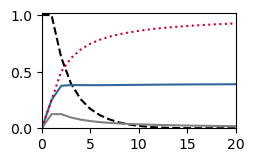

In [29]:
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,output["relative_number_females"].adult,color = "k","--")  
PyPlot.plot(0:t,output["allelefreq_zygote"].B2,color = "#336699","-")  
PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "grey","-")   
PyPlot.plot(0:t,output["allelefreq_zygote"].C2,color = "#CC0033",":")   

PyPlot.xlim(0,20)
PyPlot.ylim(0,1.02)

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.ylim(0.01,0.3)

PyPlot.show()

### Supplementary Figure 3 and 4

#### Fig 3 top row

In [13]:
#Load in unboosted

@load "./results/SingleLocus/SIT_0.05.jld2"
SIT_rrr = lab_rrr

@load "./results/SingleLocus/RIDL_0.05.jld2"
RIDL_rrr = lab_rrr

@load "./results/SingleLocus/fsRIDL_0.05.jld2"
fsRIDL_rrr = lab_rrr

@load "./results/SingleLocus/XS_0.05.jld2"
XS_rrr = lab_rrr

@load "./results/SingleLocus/MDFS_0.05.jld2"
MDFS_rrr = lab_rrr

@load "./results/SingleLocus/PDNE_0.05.jld2"
PDNE_rrr = lab_rrr;


In [ ]:
#plot repeat releases of the above release rate to check
for Gen in [1,2,3]
    Gen_index = [5,20,36][Gen]
    f1 = PyPlot.figure(figsize=(2.5,2.5))
    Rm_vec = collect(2:20)

    y = SIT_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","--") 

    y = RIDL_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "lightblue","-") 

    y = fsRIDL_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 

    y = XS_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

    y = MDFS_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "green","-") 

    y =  PDNE_rrr
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "magenta","-") 
    
    #y =  biRec_rrr
    #PyPlot.plot(Rm_vec,y[Gen,:],color = "blue","-") 


    PyPlot.xlim(0,20)
    PyPlot.yscale("log")
    PyPlot.ylim(0.01,20)
    #PyPlot.ylim(0,60)
    PyPlot.title("Gen = $Gen_index")
    PyPlot.yticks([0.001,0.002,0.005,0.01,0.02,0.05,0.10,0.20,0.50,1,2,5,10,20],[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20])
    
    PyPlot.show()
end

#### Find release rates for boosted constructs

In [14]:
threshold = 0.05

0.05

###### Boosted PDNE

In [15]:
#Homing booster setup
pdict = Dict()

#PDNE at the B locus
pdict[cH]=1.0

pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[sgm]=1.0
pdict[hgm]=0.0

pdict[srf]=1.0
pdict[hrf]=1.0
pdict[srm]=1.0
pdict[hrm]=1.0

#HI at the C locus
pdict[c]=1.0

pdict[r1]=0.5
pdict[r2]=0.0

pdict[m]=0.5


0.5

In [16]:
opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);

input_vals = [genotypes_f,
            genotypes_m,
            ic_f_vals,
            ic_m_vals,
            fitness_f_vals,
            fitness_m_vals];


In [17]:
#homozygous bisex PDNE no booster
n_releases_vec = collect(1:36)
n_releases_vec = [5,20,36]
Rm_vec = collect(2:20)
rrr_biPDNE_homs = Array{Float64}(undef,length(n_releases_vec),length(Rm_vec))
fitness = "a"
y=0
for Rm in Rm_vec
    y=y+1
    x=1
    for n_releases in n_releases_vec
        release_freq = 0.0

        rr = find_release_rate_required_nopm(n_releases,
                                    0.0,
                                    threshold,
                                    pdict,
                                    input_vals;
                                    release_genotype=["A2" "A2"; "B1" "B2"; "C1" "C1"],
                                    t=n_releases,
                                    Rm = Rm,
                                    accuracy=0.0001)
        rrr_biPDNE_homs[x,y] = rr
        x=x+1
    end
end
rrr = rrr_biPDNE_homs
@save "./results/HomingBooster/PDNE_homingboosted.jld2" rrr

###### Boosted fsRIDL

In [18]:
#Homing booster setup
pdict = Dict()

#PDNE at the B locus
pdict[cH]=1.0

pdict[sgf]=1.0
pdict[hgf]=1.0
pdict[sgm]=0.0
pdict[hgm]=0.0

pdict[srf]=0.0
pdict[hrf]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0

#HI at the C locus
pdict[c]=0.0

pdict[r1]=0.5
pdict[r2]=0.0

pdict[m]=0.5

0.5

In [19]:
genotypes_f,
genotypes_m,
ic_f,
ic_m,
fitness_f,
fitness_m = inputs

opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);

input_vals = [genotypes_f,
            genotypes_m,
            ic_f_vals,
            ic_m_vals,
            fitness_f_vals,
            fitness_m_vals];


In [20]:
#homozygous bisex PDNE no booster
n_releases_vec = collect(1:36)
n_releases_vec = [5,20,36]
Rm_vec = collect(2:20)
rrr_fsRIDL_homs = Array{Float64}(undef,length(n_releases_vec),length(Rm_vec))
y=0
for Rm in Rm_vec
    y=y+1
    x=1
    for n_releases in n_releases_vec
        release_freq = 0.0

        rr = find_release_rate_required_nopm(n_releases,
                                    0.0,
                                    threshold,
                                    pdict,
                                    input_vals;
                                    release_genotype=["A2" "A2"; "B2" "B2"; "C1" "C1"],
                                    Rm = Rm,
                                    t=n_releases,
                                    accuracy=0.0001)
        rrr_fsRIDL_homs[x,y] = rr
        x=x+1
    end
end
rrr=rrr_fsRIDL_homs
@save "./results/HomingBooster/fsRIDL_homingboosted.jld2" rrr

###### Boosted biRec

In [21]:
#Homing booster setup
pdict = Dict()

#PDNE at the B locus
pdict[cH]=1.0

pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[sgm]=1.0
pdict[hgm]=0.0

pdict[srf]=0.0
pdict[hrf]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0

#HI at the C locus
pdict[c]=0.0

pdict[r1]=0.5
pdict[r2]=0.0

pdict[m]=0.5

0.5

In [22]:
genotypes_f,
genotypes_m,
ic_f,
ic_m,
fitness_f,
fitness_m = inputs

opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);

input_vals = [genotypes_f,
            genotypes_m,
            ic_f_vals,
            ic_m_vals,
            fitness_f_vals,
            fitness_m_vals];


In [23]:
#homozygous bisex PDNE no booster
n_releases_vec = collect(1:36)
n_releases_vec = [5,20,36]
Rm_vec = collect(2:20)
rrr_biRec_homs = Array{Float64}(undef,length(n_releases_vec),length(Rm_vec))
fitness = "a"
y=0
for Rm in Rm_vec
    y=y+1
    x=1
    for n_releases in n_releases_vec
        release_freq = 0.0

        rr = find_release_rate_required_nopm(n_releases,
                                    0.0,
                                    threshold,
                                    pdict,
                                    input_vals;
                                    release_genotype=["A2" "A2"; "B2" "B2"; "C1" "C1"],
                                    t=n_releases,
                                    Rm = Rm,
                                    accuracy=0.0001)
        rrr_biRec_homs[x,y] = rr
        x=x+1
    end
end
rrr=rrr_biRec_homs
@save "./results/HomingBooster/biRec_homingboosted.jld2" rrr


###### Boosted XS

In [24]:
#Homing booster setup
pdict = Dict()

#PDNE at the B locus
pdict[cH]=1.0

pdict[sgf]=0.0
pdict[hgf]=0.0
pdict[sgm]=0.0
pdict[hgm]=0.0

pdict[srf]=0.0
pdict[hrf]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0

#HI at the C locus
pdict[c]=0.0

pdict[r1]=0.5
pdict[r2]=0.0

pdict[m]=1.0

1.0

In [25]:
genotypes_f,
genotypes_m,
ic_f,
ic_m,
fitness_f,
fitness_m = inputs

opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);

input_vals = [genotypes_f,
            genotypes_m,
            ic_f_vals,
            ic_m_vals,
            fitness_f_vals,
            fitness_m_vals];


In [26]:
#homozygous bisex PDNE no booster
n_releases_vec = collect(1:36)
n_releases_vec = [5,20,36]
Rm_vec = collect(2:20)
rrr_XS_homs = Array{Float64}(undef,length(n_releases_vec),length(Rm_vec))
fitness = "a"
y=0
for Rm in Rm_vec
    y=y+1
    x=1
    for n_releases in n_releases_vec
        release_freq = 0.0

        rr = find_release_rate_required_nopm(n_releases,
                                    0.0,
                                    threshold,
                                    pdict,
                                    input_vals;
                                    release_genotype=["A2" "A2"; "B2" "B2"; "C1" "C1"],
                                    t=n_releases,
                                    Rm = Rm,
                                    accuracy=0.0001)
        rrr_XS_homs[x,y] = rr
        x=x+1
    end
end
rrr=rrr_XS_homs
@save "./results/HomingBooster/XS_homingboosted.jld2" rrr


#### Fig 3 Bottom row

In [27]:
@load "./results/HomingBooster/fsRIDL_homingboosted.jld2"
fsRIDLboosted_rrr = rrr

@load "./results/HomingBooster/XS_homingboosted.jld2"
XSboosted_rrr = rrr

@load "./results/HomingBooster/PDNE_homingboosted.jld2"
PDNEboosted_rrr = rrr;

@load "./results/HomingBooster/biRec_homingboosted.jld2"
biRecboosted_rrr = rrr;


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


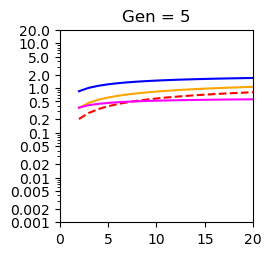

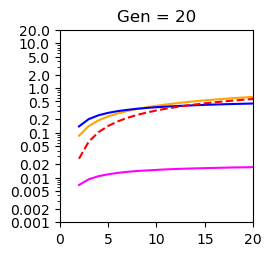

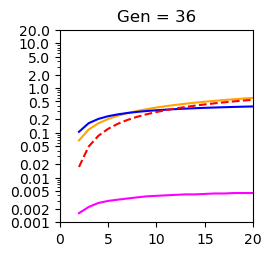

In [28]:
#plot repeat releases of the above release rate to check
for Gen_index in 1:3
    f1 = PyPlot.figure(figsize=(2.5,2.5))
    Rm_vec = collect(2:20)
    Gens = [5,20,36]

    y = fsRIDLboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "orange","-") 
    
    y = biRecboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "blue","-") 

    y = XSboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "red","--") 

    y = PDNEboosted_rrr
    PyPlot.plot(Rm_vec,y[Gen_index,:],color = "magenta","-") 


    PyPlot.xlim(0,20)
    PyPlot.yscale("log")
    PyPlot.ylim(0.01,20)
    #PyPlot.ylim(0,60)
    PyPlot.title("Gen = $(Gens[Gen_index])")
    PyPlot.yticks([0.001,0.002,0.005,0.01,0.02,0.05,0.10,0.20,0.50,1,2,5,10,20],[0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20])
    PyPlot.show()
end


#### Fig 4 top row

In [29]:
@load "./results/SingleLocus/fsRIDL_0.05.jld2"
fsRIDL_rrr = lab_rrr

@load "./results/SingleLocus/XS_0.05.jld2"
XS_rrr = lab_rrr

@load "./results/SingleLocus/PDNE_0.05.jld2"
PDNE_rrr = lab_rrr;

@load "./results/HomingBooster/fsRIDL_homingboosted.jld2"
fsRIDLboosted_rrr = rrr

@load "./results/HomingBooster/XS_homingboosted.jld2"
XSboosted_rrr = rrr

@load "./results/HomingBooster/PDNE_homingboosted.jld2"
PDNEboosted_rrr = rrr;


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


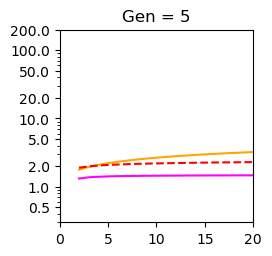

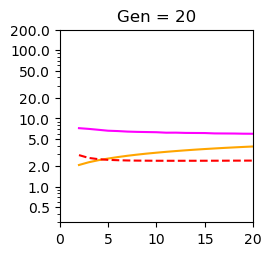

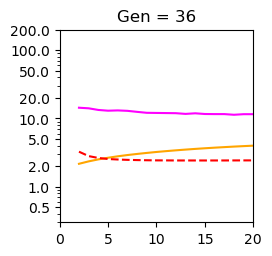

In [30]:
#plot repeat releases of the above release rate to check
for Gen_index in 1:3
    f1 = PyPlot.figure(figsize=(2.5,2.5))
    Rm_vec = collect(2:20)
    Gens = [5,20,36]

    #PyPlot.plot([0,20],[1.0,1.0],color = "lightgrey",":") 

    y = fsRIDLboosted_rrr 
    PyPlot.plot(Rm_vec,fsRIDL_rrr[Gens[Gen_index],:]./ y[Gen_index,:],color = "orange","-") 
    
    #y = biRecboosted_rrr 
    #PyPlot.plot(Rm_vec,biRec_rrr[Gen_index,:]./ y[Gen_index,:],color = "blue","-") 

    y = XSboosted_rrr 
    PyPlot.plot(Rm_vec,XS_rrr[Gens[Gen_index],:] ./ y[Gen_index,:],color = "red","--") 

    y =  PDNEboosted_rrr
    PyPlot.plot(Rm_vec,PDNE_rrr[Gens[Gen_index],:]./ y[Gen_index,:],color = "magenta","-") 


    PyPlot.xlim(0,20)
    PyPlot.yscale("log")
    PyPlot.ylim(0.3,100)
    #PyPlot.ylim(0,60)
    PyPlot.title("Gen = $(Gens[Gen_index])")
    PyPlot.yticks([0.50,1,2,5,10,20,50,100,200],[0.50,1,2,5,10,20,50,100,200])
    PyPlot.show()
end


#### Fig 4 bottom row

In [31]:

@load "./results/HomingBooster/fsRIDL_homingboosted.jld2"
fsRIDLboosted_rrr = rrr

@load "./results/HomingBooster/XS_homingboosted.jld2"
XSboosted_rrr = rrr

@load "./results/HomingBooster/PDNE_homingboosted.jld2"
PDNEboosted_rrr = rrr;

@load "./results/HomingBooster/biRec_homingboosted.jld2"
biRecboosted_rrr = rrr;


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


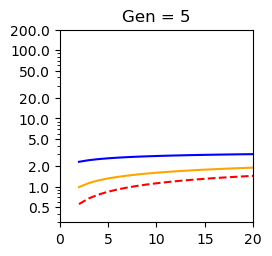

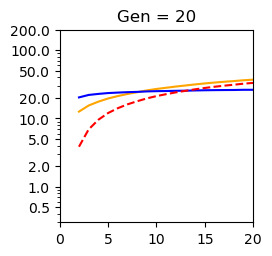

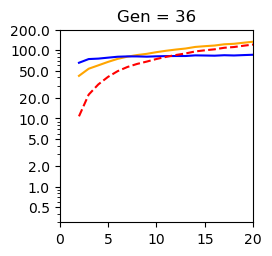

In [32]:
#plot repeat releases of the above release rate to check
for Gen_index in 1:3
    f1 = PyPlot.figure(figsize=(2.5,2.5))
    Rm_vec = collect(2:20)
    Gens = [5,20,36]

    #PyPlot.plot([0,20],[1.0,1.0],color = "lightgrey",":") 

    y = fsRIDLboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:]./PDNEboosted_rrr[Gen_index,:],color = "orange","-") 
    
    y = biRecboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:]./PDNEboosted_rrr[Gen_index,:],color = "blue","-") 

    y = XSboosted_rrr 
    PyPlot.plot(Rm_vec,y[Gen_index,:]./PDNEboosted_rrr[Gen_index,:],color = "red","--") 


    PyPlot.xlim(0,20)
    PyPlot.yscale("log")
    PyPlot.ylim(0.3,100)
    #PyPlot.ylim(0,60)
    PyPlot.title("Gen = $(Gens[Gen_index])")
    PyPlot.yticks([0.50,1,2,5,10,20,50,100,200],[0.50,1,2,5,10,20,50,100,200])

    PyPlot.show()
end


## TA booster model

Locus 1

A1 = W

A2 = B = Booster

Locus 2

B1 = W

B2 = G = PDNE construct

B3 = Edit

Locus 3

C1 = W

C2 = T = Toxin

### Load in gamete and fitness tables

In [4]:
#Define all alleles and genotypes 
loci= ["A","B","C"]
alleles = [["A1", "B1", "C1"],
         ["A1", "B1", "C2"],
         ["A1", "B2", "C1"],
         ["A1", "B2", "C2"],
         ["A1", "B3", "C1"],
         ["A1", "B3", "C2"],
         ["A2", "B1", "C1"],
         ["A2", "B1", "C2"],
         ["A2", "B2", "C1"],
         ["A2", "B2", "C2"],
         ["A2", "B3", "C1"],
         ["A2", "B3", "C2"]]

genotypes = []
for i in 1:length(alleles)
    allele1 = alleles[i]
    for j in i:length(alleles)
        allele2 = alleles[j]
        push!(genotypes,([allele1 allele2]))
    end
end;
genotypes_m = genotypes
genotypes_f = genotypes;
falleles = alleles
malleles = alleles;

In [5]:
#Define symbols (don't change)
sgf, hgf, srf, hrf, sgrf, sgm, hgm, srm, hrm, sgrm, stcf, htcf,stcm, htcm, c, cT, r1, r2 = Sym("sgf hgf srf hrf sgrf sgm hgm srm hrm sgrm stcf htcf stcm htcm c cT r1 r2")

#Read in genotypes from storage
genotypes_f_string = [string(genotypes_f[i][1,1]*genotypes_f[i][2,1]*genotypes_f[i][1,2]*genotypes_f[i][2,2]) for i in 1:length(genotypes_f)]
genotypes_m_string = [string(genotypes_m[i][1,1]*genotypes_m[i][2,1]*genotypes_m[i][1,2]*genotypes_m[i][2,2]) for i in 1:length(genotypes_m)]

#Read in gamete table
maternal_gt = readdlm("./TA_booster/TA_booster_MaternalGameteTable.csv", ',', String,header=true)[1]
maternal_gt = convert(Array{Any}, maternal_gt[:,2:end])
maternal_gt = eval.(Meta.parse.(maternal_gt))
maternal_gt = Sym.(maternal_gt)

paternal_gt = readdlm("./TA_booster/TA_booster_PaternalGameteTable.csv", ',', String,header=true)[1]
n_alleles = Int((length(paternal_gt[1,:])-1)/2)
paternal_gt = convert(Array{Any}, paternal_gt[:,2:end])
paternal_gt = eval.(Meta.parse.(paternal_gt))
paternal_gt = Sym.(paternal_gt)

#Read in fitness from storage
fitness_f = readdlm("./TA_booster/TA_booster_fitness_f.csv", ',', String,header=true)[1]
fitness_f = convert(Array{Any}, fitness_f[:,2:4])
fitness_f = eval.(Meta.parse.(fitness_f))
fitness_f = Sym.(fitness_f)

fitness_m = readdlm("./TA_booster/TA_booster_fitness_m.csv", ',', String,header=true)[1]
fitness_m = convert(Array{Any}, fitness_m[:,2:4])
fitness_m = eval.(Meta.parse.(fitness_m))
fitness_m = Sym.(fitness_m);

In [6]:
inputs = [genotypes_f,
    genotypes_m,
    maternal_gt,
    paternal_gt,
    fitness_f,
    fitness_m];

### Figure 5c

In [10]:
#TA booster setup
t=50
release_genotype = ["A1" "A2"; "B1" "B2"; "C1" "C1"]
release_freq=1.0
Rm=6

sgf, hgf, srf, hrf, sgrf, sgm, hgm, srm, hrm, sgrm, stcf, htcf, cb, jb, cc, jc, uc, r1, r2 = Sym("sgf hgf srf hrf sgrf sgm hgm srm hrm sgrm stcf htcf cb jb cc jc uc r1 r2")

pdict = Dict()

#PDNE at the B locus
pdict[c]=1.0

pdict[sgf]=1.0
pdict[hgf]=0.0
pdict[srf]=1.0
pdict[hrf]=1.0
pdict[sgrf]=1.0

pdict[sgm]=1.0
pdict[hgm]=0.0
pdict[srm]=0.0
pdict[hrm]=0.0
pdict[sgrm]=0.0

#HI at the C locus
pdict[cT]=1.0

#Female specific HS target for TA booster
pdict[stcf]=1.0
pdict[htcf]=0.0
pdict[stcm]=0.0
pdict[htcm]=0.0

pdict[r1]=0.05
pdict[r2]=0.5

#Dynamics params
params = Dict()
Nf_eq = 1000.0
params["OJ"] = 1/10
params["f"] = (2*Rm)/params["OJ"]
params["α"] = params["f"]*Nf_eq/(Rm-1)

opt_subs_pdict = deepcopy(pdict)
opt_subs_list = [(param,opt_subs_pdict[param]) for param in keys(pdict)];

#Fitness
fitness_f_vals = Array{Float64}(fitness_f.subs(opt_subs_list))
fitness_m_vals = Array{Float64}(fitness_m.subs(opt_subs_list))

maternal_gt_vals = Array{Float64}(maternal_gt.subs(opt_subs_list))
paternal_gt_vals = Array{Float64}(paternal_gt.subs(opt_subs_list))

ic_f_vals,ic_m_vals  = make_ics(maternal_gt_vals,paternal_gt_vals);

input_vals = [genotypes_f,
            genotypes_m,
            ic_f_vals,
            ic_m_vals,
            fitness_f_vals,
            fitness_m_vals];


In [11]:
#Simulate
t=50
release_genotype = ["A1" "A2"; "B1" "B2"; "C1" "C1"]
release_freq=1.0

#Set up release
starting_population_Nf,starting_population_Nm = Initiate_prerelease_population_4lifestages(params, genotypes_m,genotypes_f)
starting_population_post_release_m = release_transgenic_males(starting_population_Nm,release_genotype,release_freq,genotypes_m)
starting_population_post_release = [starting_population_Nf,starting_population_post_release_m]

output = Simulate_timeseries(t,             #number of generations
                            starting_population_post_release, #[1] = female, [2] = male
                            genotypes_m,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]
                            genotypes_f,     #list of genotypes, each entry = ["A1" "A2"; "B1" "B2"]) 
                            ic_f_vals,
                            ic_m_vals,
                            fitness_f_vals,
                            fitness_m_vals,
                            params)
        
output = Simulation_processing_wrapper(output,falleles,malleles,genotypes_f,genotypes_m);

alleles_list = [["A1", "A2"]
             ["B1", "B2", "B3"]
             ["C1", "C2"]]

correlation_PDNEboost = Find_correlation_df(genotypes,alleles,output["genotypefreq_zygote"],alleles_list,"A2","B2");


sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


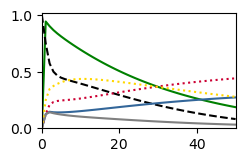

In [12]:
#plot
f1 = PyPlot.figure(figsize=(2.5,1.5))

PyPlot.plot(0:t,correlation_PDNEboost[!,"Correlation"],color = "green","-")
PyPlot.plot(0:t,output["relative_number_females"].adult,color = "k","--")  
PyPlot.plot(0:t,output["allelefreq_zygote"].B2,color = "#336699","-")  
PyPlot.plot(0:t,output["allelefreq_zygote"].B3,color = "#CC0033",":")

PyPlot.plot(0:t,output["allelefreq_zygote"].A2,color = "grey","-")

PyPlot.plot(0:t,output["allelefreq_zygote"].C2,color = "gold",":")


PyPlot.ylim(0,1.02)
PyPlot.xlim(0,50)

#PyPlot.legend(bbox_to_anchor=(1, 1))
#PyPlot.yscale("log")

PyPlot.show()
